In [75]:
import sys
import os

path = os.path.dirname(os.path.abspath("__file__"))
sys.path.insert(0, path + '/../')

from util.io import log_files
import importlib
import matplotlib.pyplot as plt
# plt.rcParams['figure.dpi'] = 150
import seaborn as sns
sns.set(rc={"figure.dpi":150, 'savefig.dpi':300})
sns.set_context('paper')

import numpy as np
import pandas as pd

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import tikzplotlib

_ = importlib.reload(log_files)

# Evaluation

The goal of our experiments is to evaluate the quality of the latent MDP learned and the policy distilled via our Variational MDP framework. This evaluation consists in
1. an analysis of the training and execution phase of our latent spaces learned and the benefits of our method to avoid posterior collapse
2. the convergence of the objective (local ELBO)
3. testing the performance (in terms of rewards) of the distilled policy in the real environment to asses if it successfully compress the input policy into the latent spaces learned
4. computing (PAC) upper bounds on local losses to asses the quality of our abstraction

We evaluate our method on classic OpenAI environments (cite) with continuous states and discrete actions (CartPole, MountainCar, and Acrobot) and on environments with continuous states and actions (Pendulum and LunarLander). We distill RL policies learned through DQN (cite) for environments with discrete actions, and SAC (cite) for environments with continuous actions.
For each line plot, we train five different instances of our VAE with different random seeds, where the solid line corresponds to the mean and the error bands to the standard deviation.

### Plots

In [31]:
logs = {
    'CartPole': '/Users/florentdelgrange/workspace/logs/02-08-21/CartPole-v0',
    'MountainCar': '/Users/florentdelgrange/workspace/logs/02-08-21/MountainCar-v0',
    'Acrobot': '/Users/florentdelgrange/workspace/logs/30-07-21//AcrobotRandomInit-v1',
    'Pendulum': '/Users/florentdelgrange/workspace/logs/02-08-21/PendulumRandomInit-v0/*/*/*',
    # 'LunarLanderContinuous': ,#
}

df = None

for env, log_dir in logs.items():
    _df = log_files.get_event_dataframe(
        log_dir,
        tags=['eval_elbo', 'local_reward_loss', 'local_probability_loss', 'encoder_entropy',
              'state_encoder_entropy', 'policy_evaluation_avg_rewards', 'action_encoder_entropy'],
        run_name='prioritized replay',
        event_name=env,)
    df = _df if df is None else df.append(_df)
        
df

,step,value,tag,run,event
0,200,4.158521,encoder_entropy,prioritized replay,CartPole
1,400,4.158636,encoder_entropy,prioritized replay,CartPole
2,600,4.158580,encoder_entropy,prioritized replay,CartPole
3,800,4.158513,encoder_entropy,prioritized replay,CartPole
4,1000,4.158483,encoder_entropy,prioritized replay,CartPole
...,...,...,...,...,...
8525,820000,0.524122,local_probability_loss,prioritized replay,Pendulum
8526,820000,0.434342,state_encoder_entropy,prioritized replay,Pendulum
8527,820000,0.321396,action_encoder_entropy,prioritized replay,Pendulum
8528,820200,0.432742,state_encoder_entropy,prioritized replay,Pendulum


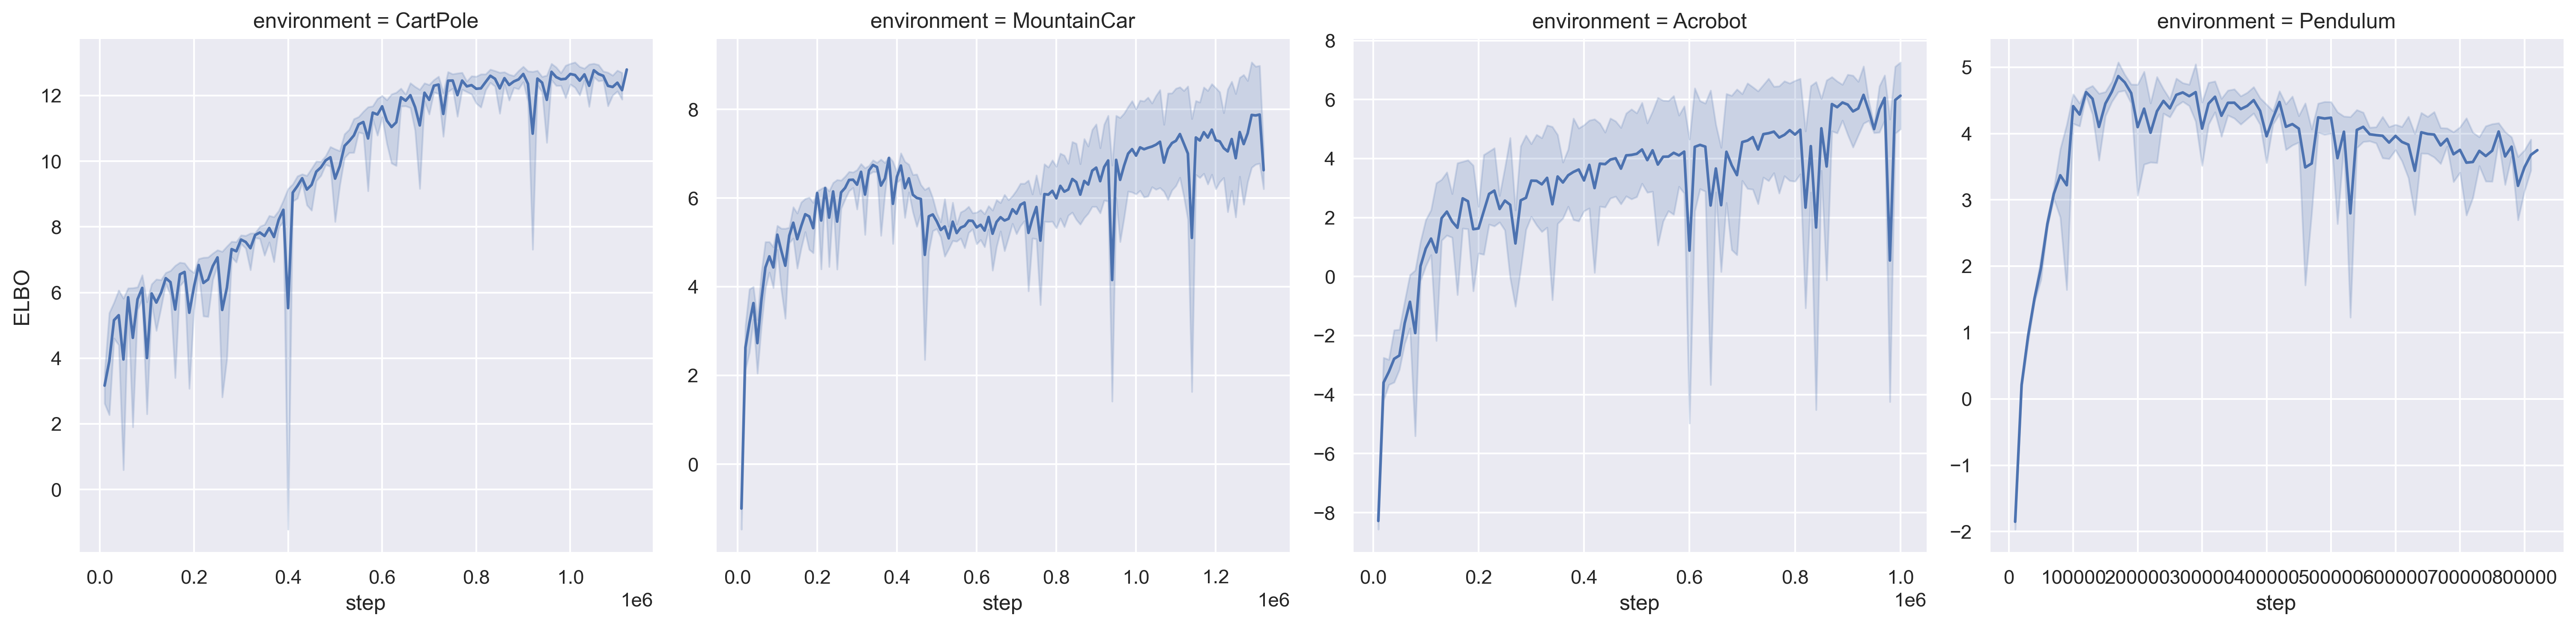

In [79]:
log_files.plot_elbo_evaluation(df, compare_environments=True, aspect=1, relplot=True)
tikzplotlib.save("eval_elbo.tex")

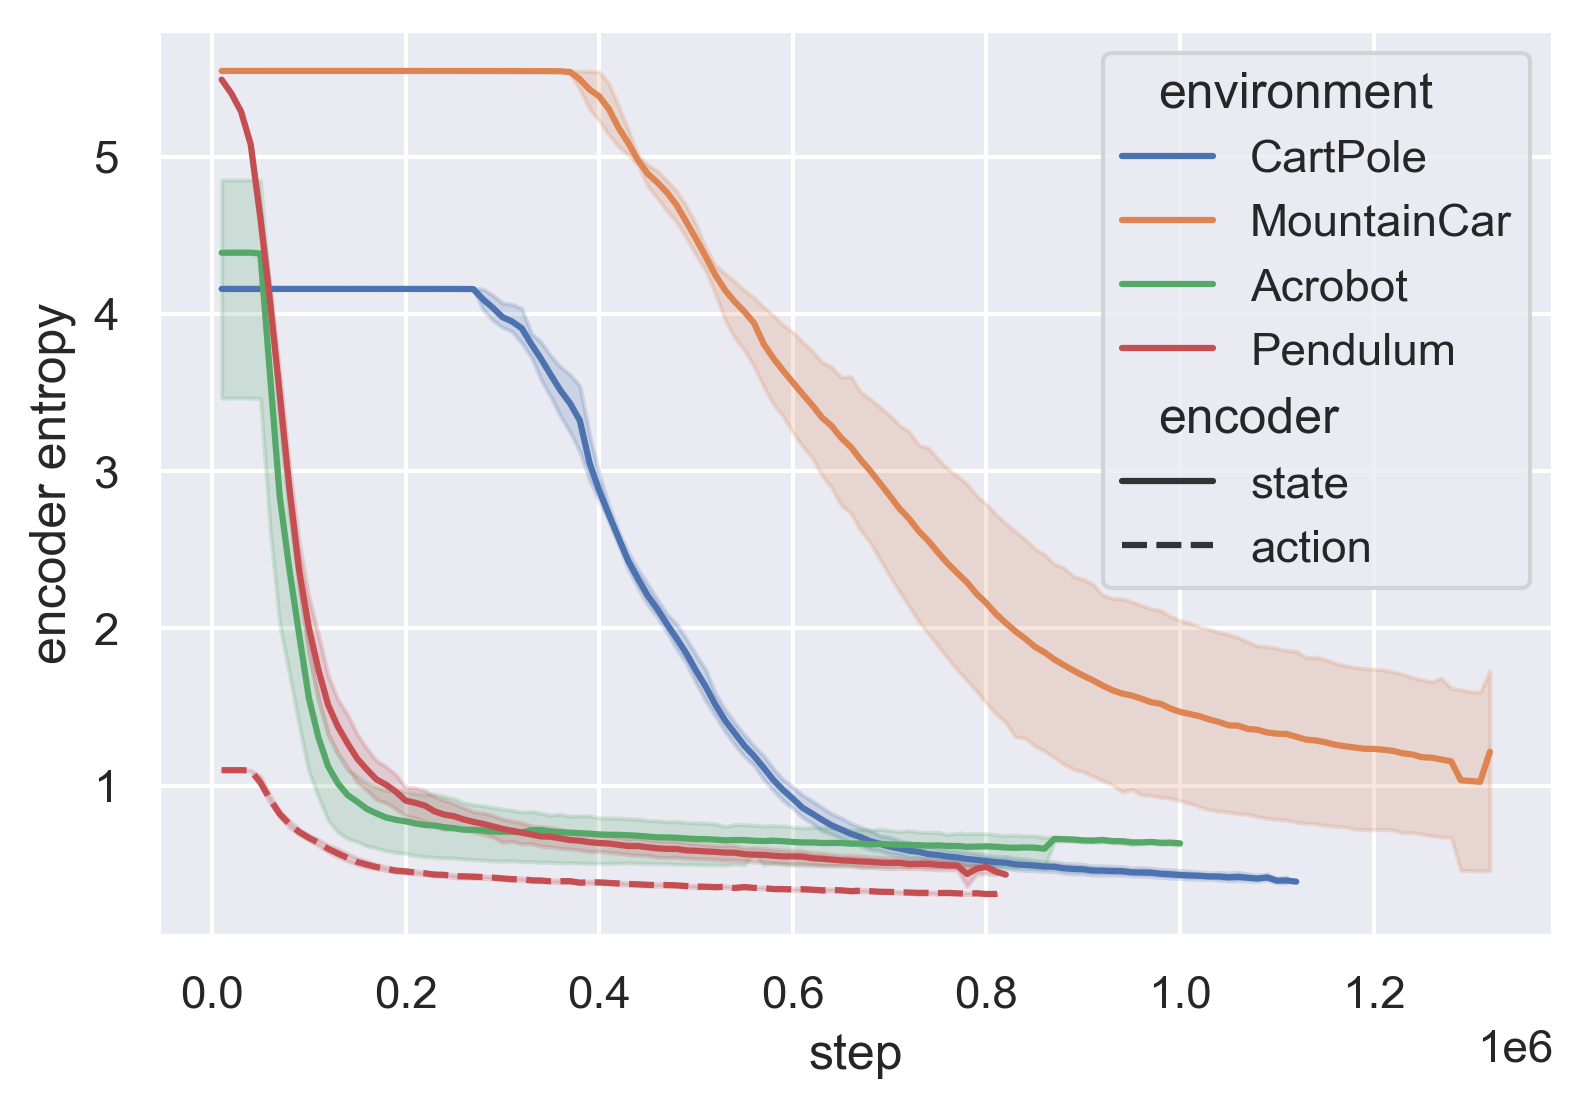

In [66]:
_df1 = df[df['event'] != 'Pendulum']
_df1 = _df1[_df1['tag'] == 'encoder_entropy']
_df2 = df[df['event'] == 'Pendulum']
_df3 = _df2[_df2['tag'] == 'state_encoder_entropy']
_df2 = _df3.append(_df2[_df2['tag'] == 'action_encoder_entropy'])
_df = _df1.append(_df2)
_df['tag'] = _df['tag'].replace({
    'encoder_entropy': 'state',
    'state_encoder_entropy': 'state',
    'action_encoder_entropy': 'action'})

sns.lineplot(
    data=_df[_df['step'] % int(1e4) == 0].rename(
        columns={
            "value": "encoder entropy",
            "event": "environment",
            "tag": "encoder"}),
    x='step',
    y='encoder entropy',
    hue="environment",
    style="encoder",
    legend='brief')
tikzplotlib.save("encoder_entropy.tex")

In [ ]:
importlib.reload(log_files)

log_files.plot_policy_evaluation(
    df,
    plot_best=True,
    original_policy_expected_rewards={
        'CartPole': 200,
        'MountainCar': -100.2,
        'Acrobot': -66.2,
        'Pendulum': -149.77565,
    },
    compare_environments=True,
    aspect=1,
    relplot=True)

tikzplotlib.save("eval_policy.tex")

### Training phase 
Figure~\ref{fig:eval-elbo}